# Multimodal Transformer Model - MOSEI

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 612 (delta 14), reused 41 (delta 12), pack-reused 565 (from 2)
Receiving objects: 100% (612/612), 446.95 MiB | 52.08 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Updating files: 100% (47/47), done.


In [2]:
!pip install memory_profiler

In [3]:
import gdown

file_id = "180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz"
destination = "mosei_senti_data.pkl"  

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz
From (redirected): https://drive.google.com/uc?id=180l4pN6XAv8-OAYQ6OrMheFUMwtqUWbz&confirm=t&uuid=e9e6ac8f-d8b8-4930-b8c5-facdafee2b4a
To: /content/mosei_senti_data.pkl
100%|██████████| 3.73G/3.73G [00:26<00:00, 141MB/s]


'mosei_senti_data.pkl'

## Importing Libraries

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import Identity
from fusions.multimodal import MULTModel
from training.supervised import train, test
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
train_data, valid_data, test_data = get_dataloader('/content/mosei_senti_data.pkl', max_pad=True)

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [8]:
class HParams():
    num_heads = 8
    layers = 4
    attn_dropout = 0.1
    attn_dropout_modalities = [0, 0, 0.1]
    relu_dropout = 0.1
    res_dropout = 0.1
    out_dropout = 0.1
    embed_dropout = 0.2
    embed_dim = 40
    attn_mask = True
    output_dim = 1
    all_steps = False

encoders = [
    Identity().to(device),
    Identity().to(device),
    Identity().to(device),
]

fusion = MULTModel(3, [35, 74, 300], hyp_params=HParams).to(device)

head = Identity().to(device)

## Training

In [9]:
OUTPUT_MODEL_FILE_NAME = "MOSEI_Multimodal_Transformer"

train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    20,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=False,
    is_packed=False,
    lr=1e-3,
    clip_val=1.0,
    save=f'/content/{OUTPUT_MODEL_FILE_NAME}.pt',
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/20]
Train Loss: 0.7725
Valid Loss: 0.7245
Saving Best

Epoch [2/20]
Train Loss: 0.6784
Valid Loss: 0.6499
Saving Best

Epoch [3/20]
Train Loss: 0.6569
Valid Loss: 0.6530

Epoch [4/20]
Train Loss: 0.6407
Valid Loss: 0.6176
Saving Best

Epoch [5/20]
Train Loss: 0.6289
Valid Loss: 0.6333

Epoch [6/20]
Train Loss: 0.6205
Valid Loss: 0.6311

Epoch [7/20]
Train Loss: 0.6114
Valid Loss: 0.6117
Saving Best

Epoch [8/20]
Train Loss: 0.6090
Valid Loss: 0.6125

Epoch [9/20]
Train Loss: 0.5974
Valid Loss: 0.6075
Saving Best

Epoch [10/20]
Train Loss: 0.5943
Valid Loss: 0.6201

Epoch [11/20]
Train Loss: 0.5852
Valid Loss: 0.6638

Epoch [12/20]
Train Loss: 0.5803
Valid Loss: 0.5945
Saving Best

Epoch [13/20]
Train Loss: 0.5758
Valid Loss: 0.5972

Epoch [14/20]
Train Loss: 0.5731
Valid Loss: 0.5975

Epoch [15/20]
Train Loss: 0.5680
Valid Loss: 0.6267

Epoch [16/20]
Train Loss: 0.5609
Valid Loss: 0.6034

Epoch [17/20]
Train Loss: 0.5570
Valid Loss: 0.6234

Epoch [18/20]
Train Loss: 0.5523
Val

Text(0.5, 1.0, 'Loss vs. No. of epochs')

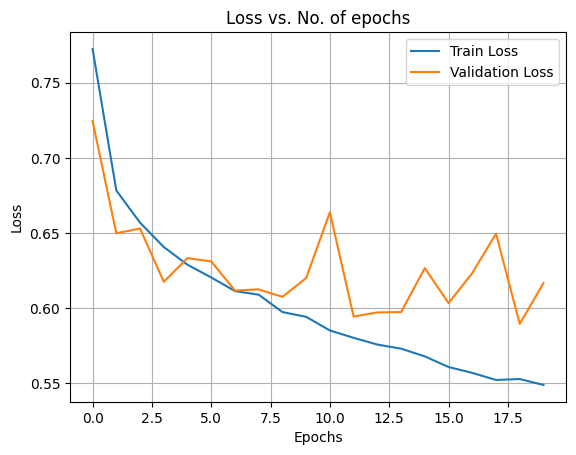

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [11]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [13]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_dataloaders_all=test_data,
    is_packed=False,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-13-fc52f287b6aa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/content/{OUTPUT_MODEL_FILE_NAME}.pt').to(device)


Recall: 80.6630% | Total Accuracy: 70.4071%
Inference Time: 9s934ms
Inference Params: 3080321
